[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UNSW-COMP9418/Week04/blob/main/COMP9418_W04_Variable_Elimination_In_Graphical_Models.ipynb)

# Variable Elimination in Graphical Models

**COMP9418 W04 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Gustavo Batista and Jeremy Gillen
- Last Update 6th September 2022
$$
% macros
\newcommand{\indep}{\perp \!\!\!\perp}
$$

In this week's tutorial, we will implement and investigate the efficiency of the Variable Elimination (VE) algorithm and the min-degree heuristic for finding a good elimination order.

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using Google Colab or ``conda``'s default [full installation](https://conda.io/docs/install/full.html), these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management, you may need to run this command:

```python
pip3 install matplotlib
```

To render a visualization of some graphical models, you also need to install Graphviz [download page](http://www.graphviz.org/download). We have already used this library in Tutorial 1, thus, you should have it installed.

Once we have done all that, we import some useful modules for later use.

In [1]:
# combinatorics
from itertools import product, combinations, permutations
# visualise plots
import matplotlib.pyplot as plt
# math library to get access to math.inf
import math

Import classes from `DiscreteFactors.py`, `Graph.py` and `BayesNet.py` developed in previous tutorials. If you are using Colab, upload the files by clicking the "files" ![File](img/file.png) button on the left side of the page, then the "upload files" ![Upload](img/upload.png)
button. Then select the relevant python files.

In [2]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet import BayesNet

## The ICU network

Once again we will use a subset of the ICU-Alarm network. You should remember this Bayesian Network from Week 3 tutorial. In any case, this is a graphical representation of the nine nodes we will use in this tutorial.

![ICU Graph](img/ICU_graph.png "Graph exercise")

In the Week 3 Tutorial, we learned the ICU Alarm network parameters from data. This week, we will simplify the code and provide the conditional probability tables (CPTs) directly. We defined a BayesNet named `ICU_Net` with the CPTs of the nine variables in the subset of the ICU-Alarm network.

The `ICU_Net.factors` dictionary associates a key, in this case, the name of the child node, to each factor. Initially, each factor is a CPT. However, as we multiply factors, we will generate tables of different formats. Some of these factors will not be probability distributions. Therefore, we use the name "factor" to designate a generalization of the idea of a CPT.

As we work with factors, our code will be equally prepared to work with Bayesian and Markov networks we will see in a future lecture.

Let's start defining the Bayes Net for ICU-Alarm network. Instead of learning the parameters from data, we will define them directly.

In [3]:
# define Bayes Net Graph
graph = Graph({
    'L': ['S', 'V'],
    'H': ['S', 'V'],
    'S': ['O'],
    'V': ['C', 'O'],
    'O': ['B'],
    'A': ['T'],
    'T': ['B'],
    'C': [],
    'B': [],
})
# Define outcome space of each random variable
outcomeSpace = dict(
    H=(0,1),
    L=(0,1),
    A=(0,1),
    V=(0,1),
    S=(0,1),
    T=(0,1),
    C=(0,1,2),
    O=(0,1,2),
    B=(0,1,2),
)
# Initialize Bayesian Network object
ICU_Net = BayesNet(graph, outcomeSpace)

# Add each factor one by one to the ICU_Net object
h = Factor(('H',), outcomeSpace)
h[0] = 0.8
h[1] = 0.2
ICU_Net.factors['H'] = h

v = Factor(('L', 'H', 'V'), outcomeSpace)
v[0, 0, 0] = 0.05
v[0, 0, 1] = 0.95
v[0, 1, 0] = 0.99
v[0, 1, 1] = 0.01
v[1, 0, 0] = 0
v[1, 0, 1] = 1
v[1, 1, 0] = 1
v[1, 1, 1] = 0
ICU_Net.factors['V'] = v

c = Factor(('V', 'C'), outcomeSpace)
c[0, 0] = 0.94
c[0, 1] = 0.04
c[0, 2] = 0.02
c[1, 0] = 0.02
c[1, 1] = 0.26
c[1, 2] = 0.72
ICU_Net.factors['C'] = c

l = Factor(('L',), outcomeSpace)
l[0] = 0.95
l[1] = 0.05
ICU_Net.factors['L'] = l

s = Factor(('L','H','S'), outcomeSpace)
s[0, 0, 0] = 0.04
s[0, 0, 1] = 0.96
s[0, 1, 0] = 0.48
s[0, 1, 1] = 0.52
s[1, 0, 0] = 0.95
s[1, 0, 1] = 0.05
s[1, 1, 0] = 0
s[1, 1, 1] = 1
ICU_Net.factors['S'] = s

o = Factor(('S', 'V', 'O'), outcomeSpace)
o[0, 0, 0] = 0.97
o[0, 0, 1] = 0.01
o[0, 0, 2] = 0.02
o[0, 1, 0] = 0.78
o[0, 1, 1] = 0.19
o[0, 1, 2] = 0.03
o[1, 0, 0] = 0.22
o[1, 0, 1] = 0.76
o[1, 0, 2] = 0.02
o[1, 1, 0] = 0.01
o[1, 1, 1] = 0.01
o[1, 1, 2] = 0.98  
ICU_Net.factors['O'] = o

t = Factor(('A','T'), outcomeSpace)
t[0, 0] = 0.30
t[0, 1] = 0.70
t[1, 0] = 1
t[1, 1] = 0
ICU_Net.factors['T'] = t

b = Factor(('O', 'T', 'B'), outcomeSpace)
b[0, 0, 0] = 1
b[0, 0, 1] = 0
b[0, 0, 2] = 0
b[0, 1, 0] = 0.30
b[0, 1, 1] = 0.62
b[0, 1, 2] = 0.08
b[1, 0, 0] = 0.93
b[1, 0, 1] = 0.07
b[1, 0, 2] = 0
b[1, 1, 0] = 0.02
b[1, 1, 1] = 0.49
b[1, 1, 2] = 0.49
b[2, 0, 0] = 0.90
b[2, 0, 1] = 0.08
b[2, 0, 2] = 0.02
b[2, 1, 0] = 0.01
b[2, 1, 1] = 0.08
b[2, 1, 2] = 0.91 
ICU_Net.factors['B'] = b

a = Factor(('A',), outcomeSpace)
a[0] = 0.99
a[1] = 0.01
ICU_Net.factors['A'] = a


## Elimination Order Width

Let's start our code with a straightforward function that will help us to build more complex ones. An essential concept in variable elimination is the `width` of an elimination order. It is defined as the number of variables (after summation) of the largest factor created during the execution of the Variable Elimination (VE) algorithm.

The `width` of an elimination order is a measure of its quality. Elimination orders with small `width` tend to be more efficient than the ones with larger `width`.

We can efficiently compute the `width` of an elimination order by simulating the VE algorithm. The idea is that we will keep track of the factor domains, but we will not perform the multiplication and summation of factors. 

### Exercise

We will implement our first function `width` that returns the width of an elimination order. 
This function will take an elimination order (list of variable names), and go through the motions of Variable Elimination to find the width of this order.

In [5]:
class BayesNet(BayesNet):
    def width(self, order):
        """
        argument 
        `order`, a list of variable names specifying an elimination order.

        Returns the width of the elimination order, i.e., the number of variables of the largest factor
        """   
        # Initialize w, a variable that has a width of the elimination order
        w = 0
        # Let's make a list of tuples, where each tuple is a factor domain. Create one tuple for each factor in the BN
        factorList = ... # TODO 1 or 2 lines
        # We process the factor in elimination order
        for var in order:
            # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
            newFactorDom = set()
            # A list to keep track of all the factors we will keep for the next iteration (all factors not containing `var`)
            updatedFactorsList = list()            

            # Lets iterate over all factors
            for f_dom in factorList:
                # and select the ones that have the variable to be eliminated
                if var in f_dom:
                    # Merge the selected domain `f_dom` into the `newFactorDomain` set, simulating a join operation
                    ... # TODO 1 line
                else:
                    # since it doesn't contain `var`, we add the `var` factor to the updatedFactorsList to be processed in the next iteration
                    ... # TODO 1 line

            # Now, we need to remove var from the domain of the new factor. We are simulating a summation
            ...         # TODO Remove var from the set newFactorDom by calling the method remove(). 1 line
            # Let's check if we have found a new largest factor
            if len(newFactorDom) > w:
                w = len(newFactorDom)
            # add the new combined factor domain to the list
            updatedFactorsList.append(newFactorDom)
            # replace factor list with updated factor list (getting rid of all factors containing var)
            factorList = updatedFactorsList

        return w

# reinitialise ICU_net so that it has width function
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

######################
# Test code

print("Elimination order width: %d" % ICU_Net.width(['V', 'H', 'S', 'L', 'O', 'A', 'T', 'B', 'C']))

TypeError: 'ellipsis' object is not iterable

If you implemented your code correctly, you should see the following output:

```
Elimination order width: 5
```

There are several observations about the `width` function:

1. Each iteration eliminates one variable in the list `order`.
2. The elimination is achieved by scanning `factors` and finding all factors whose domain has the elimination variable.
3. We simulate the join operation by creating a list with all variables present in factors that contain the elimination variable.
4. We remove the elimination variable before we compute the `width`. Therefore, we obtain the value according to the definition.
5. We simulate the creation of a new factor and insert this dummy factor in the dictionary of factors.

## Variable Elimination (VE) Algorithm

Let's use the previous function to implement the first version of our VE algorithm. We will need the join and marginalize operations implemented in the earlier tutorials in the Factor class. 


### Exercise

Now we are in the position to implement the function `VE` that will execute the Variable Elimination algorithm for a given variable order. The code is very similar to the `width` function, except instead of only keeping track of the factor domains, we will keep track of the whole factor objects. 

As part of this exercise, we will use global variables `muls` and `adds` to count the number of multiplications and additions that will during the join and marginalize operations. We will use this to measure the efficiency of the algorithm. Do this part of the algorithm after getting the function working. For this exercise, it may be useful to know that if `f` is a factor object, you can use `f.table.size` to get the number of elements in the table that makes up that factor. This is useful when working out how many multiplications occured in a join operation, and how many additions happened in a marginalize operation.

In [5]:
class BayesNet(BayesNet):
    def VE(self, order):
        """
        argument 
        `order`, a list of variable names specifying an elimination order.

        Returns a single factor, the which remains after eliminating all other factors
        """   
        global muls, adds
        # Let's make a list of all factor objects
        factorList = ... # 1 line

        for var in order:
            # We create an empty factor as an accumulator
            newFactor = Factor(tuple(), self.outcomeSpace)
            first = True
            # A list to keep track of all the factors we will keep for the next step
            updatedFactorsList = list()            

            for f in factorList:
                # and select the ones that have the variable to be eliminated
                if var in f.domain:
                    # join the factor `f` with the accumulator `newFactor`
                    newFactor = ... # TODO 1 line
                    if not first:
                        muls += newFactor.table.size # keep track of multiplications being done with each join operation
                    first = False
                        
                else:
                    # since the factor `f` doesn't contain `var`, we will keep it for next iteration
                    ... # TODO 1 line
                    
            # Now, we need to remove var from the domain of the new factor. 
            adds += newFactor.table.size # keep track of the number of additions being done in the following marginalization
            newFactor = ... # TODO marginalize out `var`
            # append the new combined factor to the factor list
            updatedFactorsList.append(newFactor)
            # replace factorList with the updated factor list, ready for the next iteration
            factorList = updatedFactorsList
        # for the final step, we join all remaining factors (usually there will only be one factor remaining)
        returnFactor = Factor(tuple(), self.outcomeSpace)
        for f in factorList:
            returnFactor = returnFactor*f
        return returnFactor


######################
# Test code

# reinitialise ICU_net so that it has VE function
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

adds = 0
muls = 0

print(ICU_Net.VE(['V', 'H', 'S', 'L', 'O', 'A', 'T', 'B']))
print("Number of additions: %d" %adds)
print("Number of multiplications: %d" %muls)

TypeError: 'ellipsis' object is not iterable

If you implemented your code correctly, you should see the following output:

```
╒═════╤══════════╕
│   C │       Pr │
╞═════╪══════════╡
│   0 │ 0.237212 │
├─────┼──────────┤
│   1 │ 0.208058 │
├─────┼──────────┤
│   2 │ 0.55473  │
╘═════╧══════════╛

Number of additions: 355
Number of multiplications: 342
```

## Inference by Enumeration

It is unclear how good these numbers of additions and multiplications are. We need to compare them with other elimination orders. However, we will first compute the number of operations required by inference by enumeration. Inference by enumeration will provide an upper-bound of the number of operations as well as an idea of the VE efficiency.

Reminder that inference by enumeration is the algorithm that joins all factors before eliminating any variables. We implemented this algorithm last week, this time we will count `adds` and `muls`.

## Exercise

Implement the `inferenceByEnum` function by changing the order of the operations. Join all factors first and then eliminate the variables in `order`.

In [7]:
class BayesNet(BayesNet):
    def inferenceByEnum(self, order):
        global muls, adds
        # Let's make a list of factors
        factorList = ... # TODO 1 line
        
        # Create an empty factor as accumulator 
        newFactor = ... # TODO 1 line

        first = True
        # Lets iterate over all factors
        for f in factorList:
            newFactor = ... # TODO join 1 line
            if not first:
                ... # TODO count multiplications 1 line
            first = False
            
        for var in order:
            # Now, we need to remove var from the domain of the new factor.
            ... # TODO count additions 1 line
            newFactor = ... # TODO marginalize 1 line

        return newFactor


######################
# Test code

# reinitialise ICU_net so that it has VE function
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

adds = 0
muls = 0
print(ICU_Net.inferenceByEnum(['V', 'H', 'S', 'L', 'O', 'A', 'T', 'B']))
print("Number of additions: %d" %adds)
print("Number of multiplications: %d" %muls)        

TypeError: 'ellipsis' object is not iterable

If you implemented your code correctly, you should see the following output:

```
╒═════╤══════════╕
│   C │       Pr │
╞═════╪══════════╡
│   0 │ 0.237212 │
├─────┼──────────┤
│   1 │ 0.208058 │
├─────┼──────────┤
│   2 │ 0.55473  │
╘═════╧══════════╛

Number of additions: 3411
Number of multiplications: 4280
```

## Width and Number of Operations

An interesting question is how the width measure correlates with the actual number of addition and multiplication operations. We can plot these two measures of inference efficiency.

### Exercise

Compare the number of multiplications with the width of the elimination order. We have created a piece of code that does part of the work for you. The idea is to generate all possible permutations of the elimination list and measure the width and number of multiplications. We will work with only seven variables since the number of permutations grows exponentially with the number of variables.

In [10]:
# List with width of all permutations of the elimination list ('V', 'H', 'S', 'L', 'O', 'A', 'T')
widthList = []
# List with number of multiplications ofr the same permutations
mulList = []
for i, perm in enumerate(permutations(('V', 'H', 'S', 'L', 'O', 'A', 'T'))):
    # Call the width function for the permutation in p
    w = ... # TODO compute width of order. 1 line
    widthList.append(w)
    # Initialize muls
    muls = 0    
    # Call the VE function to compute the number of multiplications
    ... # TODO 1 line
    mulList.append(muls)
    # Print some information since it may take some time to finish
    if (i % 100 == 0):
        print("%6d %6d %1.6f" % (i, w, muls))
# Generate plots
plt.plot(widthList, mulList, 'ro')
plt.xlabel("Width")
plt.ylabel("Number of muls")
plt.show()

TypeError: %d format: a number is required, not ellipsis

     0      5 342.000000
   100      5 347.000000
   200      5 442.000000
   300      5 558.000000
   400      6 874.000000
   500      5 333.000000
   600      5 374.000000
   700      5 428.000000
   800      4 298.000000
   900      4 250.000000
  1000      3 111.000000
  1100      5 498.000000
  1200      4 226.000000
  1300      4 280.000000
  1400      4 258.000000
  1500      5 490.000000
  1600      4 159.000000
  1700      4 314.000000
  1800      5 490.000000
  1900      5 582.000000
  2000      5 330.000000
  2100      4 314.000000
  2200      4 199.000000
  2300      4 266.000000
  2400      3 178.000000
  2500      3 183.000000
  2600      4 186.000000
  2700      4 250.000000
  2800      4 212.000000
  2900      6 770.000000
  3000      5 370.000000
  3100      5 402.000000
  3200      5 306.000000
  3300      4 274.000000
  3400      4 180.000000
  3500      6 702.000000
  3600      5 342.000000
  3700      5 396.000000
  3800      4 226.000000
  3900      4 282.000000


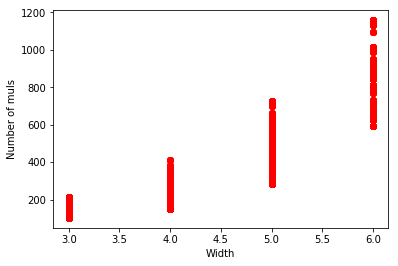

In [11]:
# List with width of all permutations of the elimination list ('V', 'H', 'S', 'L', 'O', 'A', 'T')
widthList = []
# List with number of multiplications ofr the same permutations
mulList = []
for i, perm in enumerate(permutations(('V', 'H', 'S', 'L', 'O', 'A', 'T'))):
    # Call the width function for the permutation in p
    w = ICU_Net.width(perm)
    widthList.append(w)
    # Initialize muls
    muls = 0    
    # Call the VE function to copermte the number of multpermications
    ICU_Net.VE(perm)
    mulList.append(muls)
    # Print some information since it may take some time to finish
    if (i % 100 == 0):
        print("%6d %6d %1.6f" % (i, w, muls))
# Generate plots
plt.plot(widthList, mulList, 'ro')
plt.xlabel("Width")
plt.ylabel("Number of muls")
plt.show()

We can see that width correlates well with the number of multiplications. More importantly, small widths have a small variance that indicates a good performance independently of a specific order. The plot appears to grow exponentially.

## Min-degree heuristic

Having a good ordering is central to VE algorithm performance. However, it is known that finding the best order is an NP-hard problem.

For a small number of variables, we can use the `width` function to test all possible orderings. The next cell implements such an approach for all nine variables.

In [12]:
minW = math.inf
for perm in permutations(['V', 'H', 'S', 'L', 'O', 'A', 'T', 'B', 'C']):
    # Call the width function for the permutation in p
    w = ICU_Net.width(perm)
    if (w < minW):
        minP = perm
        minW = w
print("Order with minimal width %d: " % minW)

print(minP)

Order with minimal width 3: 
('H', 'S', 'V', 'L', 'O', 'A', 'T', 'B', 'C')


### Exercise

For larger networks, we will need to use a heuristic approach. One of the simplest is known as min-degree. Min-degree and several other ordering heuristics operate over an undirected graph known as an *interaction graph*.

The interaction graph is simply a graph in which the nodes are variables, and the edges connect variables that appear in the domain of the same factor. 

We will start implementing `interactionGraph` a function that receives a dictionary of factors and returns an interaction graph. We use the same adjacency list representation of the first tutorial.

In [13]:
# add a function to BayesNet to get interaction graph
class BayesNet(BayesNet):
    def interactionGraph(self):
        '''
        Returns the interaction graph for this network.
        There are two ways to implement this function:
        - Iterate over factors and check which vars are in the same factors
        - Start with the directed graph, make it undirected and moralise it
        '''
        # Initialise an empty graph
        g = Graph()
        # Add each node to the graph
        for var in self.factors.keys():
            ... # TODO add node. 1 line
        for factor in self.factors.values():
            # for every pair of vars in the domain
            for var1 in factor.domain:
                for var2 in factor.domain:
                    # check if connection already exists 
                    if var1 != var2 and var1 not in g.children(var2):
                        # add an *undirected* connection
                        ... # TODO 1 line
        return g


##############
# Test code

# reinitialise ICU_net so that it has interactionGraph function
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

# List of positions for each node
# We use node positions to replicate the previous figure
# This can be removed if the nodes do not need to be presented in a specific order
pos = {
    'B': '1,0!',
    'O': '0,1!',
    'C': '1,1!',
    'T': '2,1!',
    'S': '0,2!',
    'V': '1,2!',
    'A': '2,2!',
    'L': '0,3!',
    'H': '1,3!',
}
ig = ICU_Net.interactionGraph()
ig.show(directed=False, positions=pos)

KeyError: 'H'

If your code is correct, you should see the following induced graph:

![IG Graph](img/IG.png "Graph exercise")

Also, this is the ICU network graph for reference:

![ICU Graph](img/ICU_graph.png "Graph exercise")

From this representation, we can see that a min-degree heuristic should start eliminating variables such as `A` and `C`.

### Exercise

Now, let's implement the `minDegree` function that receives an induced graph and returns a list with a variable elimination order.

This function will suggest the nodes with the smallest degree first. Remember that the degree of a node is the number of edges connected to that node. Every time we select a node as the next to be eliminated, we need to remove that node from the graph. This operation will reduce the degree of the nodes directly connected to the removed one.

In [15]:
class BayesNet(BayesNet):
    def minDegree(self):
        # First get the interaction graph
        ig = self.interactionGraph()
        # Initialize order with empty list. This variable will have the answer in the end of the execution
        order = [] 
        # While the induced graph has nodes to be eliminated
        while len(ig) > 0:
            # Initialize minDegree with a large number: math.inf
            minDegree = math.inf
            for var in ig:
                # Test if var has a degree smaller than minDegree
                if len(ig.children(var)) < minDegree:
                    # We have found a new candidate to be the next eliminated variable. Let's save its degree and name
                    minDegree = ... # TODO 1 line
                    minVar = ... # TODO 1 line
            # We need to connect the neighbours of minVar, let us start using combinations function to find all pairs of minVar's neighbours
            for var1, var2 in combinations(ig.children(minVar), 2):
                # Check if these neighbour are not already connected by an edge
                if var1 not in ig.children(var2):
                    # add edge
                    ... # TODO 1 line 
            # Insert into order the variable in minVar
            order.append(...) # TODO
            # Now, we need to remove minVar from the adjacency list of every node
            ig.remove_node(...) # TODO
        return order


####################
# Test code

# reinitialise ICU_net so that it has minDegree function
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

print(ICU_Net.minDegree())

TypeError: '<' not supported between instances of 'int' and 'ellipsis'

If your code is correct, you should see the following output:

```
['A', 'C', 'T', 'B', 'O', 'H', 'L', 'V', 'S']
```
or
```
['C', 'A', 'T', 'B', 'O', 'H', 'V', 'L', 'S']
```
We can compare the width of the ordering provided by the min-degree heuristic to some other order:

In [17]:
print(ICU_Net.width(('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B', 'C')))
order = ICU_Net.minDegree()
print(ICU_Net.width(order))

5
3


Similarly, we can compare the number of additions and multiplications:

In [18]:
adds = 0
muls = 0
ICU_Net.VE(('V', 'H', 'S', 'L', 'O', 'A', 'T', 'B', 'C'))
print(adds)
print(muls)

adds = 0
muls = 0
ICU_Net.VE(ICU_Net.minDegree())
print(adds)
print(muls)

358
342
79
74


## Answering Queries


### Exercise

Now it's your turn to implement a function `query` that receives as arguments:

1. a list of query variables 
2. and a list of evidence 

and returns $P(variables|evidence)$.

Before you start, some important observations:

* You will need to change some of the factors in the `factors` dict to set evidence on them. For this reason, we created a backup and we restore the `factors` dict after the operation.
* Remove the query variables from the elimination order list.
* It is up to you if you want to remove the evidence variables from the elimination list.
* A final normalization step will answer queries in the format P(Q|e).

In [19]:
import copy
class BayesNet(BayesNet):
    def query(self, q_vars, **q_evi):
        '''
        A faster VE-based query function
        Returns a factor P(q_vars| q_evi)
        '''
        # backup factors dict
        backup_factors = copy.deepcopy(self.factors)

        ... # TODO ~11 lines

        # restore original factors
        self.factors = backup_factors

        # Return factor P(q_vars | q_evi)
        return ... # TODO

#########################
# Test code
#########################

# reinitialise ICU_net so that it has the new query function
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

print(ICU_Net.query('L', C=2))

Ellipsis


If your implementation is correct then you should see the following output:

```
╒═════╤═══════════╕
│   L │        Pr │
╞═════╪═══════════╡
│   0 │ 0.947722  │
├─────┼───────────┤
│   1 │ 0.0522777 │
╘═════╧═══════════╛
```

## Final Step
Go back through the notebook, and copy your solutions into your BayesNet.py file for future use. Your VE function won't need to keep track of additions and multiplications in future, so you can delete these computations.

## Challenge Exercise

The Variable Elimination function implemented above loops over every variable in the elimination order, and has an inner loop over all factors to find the factors to be eliminated in each step. This algorithm takes $O(n^2)$ where $n$ is the size of the graph (ignoring the cost of joining and marginalizing factors, which is usually the main cost). 

Use an additional data structure to improve your VE implementation to be $O(n)$.

That is all for today. See you next week!